# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import kpss
import pmdarima as pm

In [3]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=InterpolationWarning)

In [4]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [76]:
plt.style.use('seaborn-v0_8')

# Helper Functions

In [5]:
def compare_item(item_code_1,item_code_2):
    '''This functions shows the descriptive information about the two comparing items.'''
    
    for c in o_col:
        if c not in ['PER_TAG','date']:
            print(c+':\t\t',df[df['ITEM_CODE']==item_code_1][c].unique(),df[df['ITEM_CODE']==item_code_2][c].unique())
            

In [6]:
def plot_timeseries(item,date,retailer):
    '''Plots trendline for given item and mentioned retailer.'''
    
    y=df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)]['VOLUME'].values
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y,'o-',color='green')
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume across the time',fontsize=20)
    plt.show()

In [7]:
def plot_corr(segment,retailer,annot=True):
    '''This functions plots the correlation heatmap for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    plt.figure(figsize=(15,12))
    sns.heatmap(dummy.corr(),annot=annot)
    plt.show()
    
def get_corr(df,segment,retailer):
    '''This functions shows the correlation coefficient values for the mentioned segment and retailer.'''
    
    dummy={}
    for item in df[(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['ITEM_CODE'].unique():
        dummy[item]=list(df[(df['ITEM_CODE']==item)&(df['RETAILER']==retailer)&(df['SEGMENT']==segment)]['VOLUME'].values)
    dummy=pd.DataFrame(dummy)
    
    return dummy.corr()

In [8]:
def get_highest(correlation_dataframe,correlation_value):
    '''This function returns the multi indexed dataframe showing items having highest correlation value'''
    
    New=pd.DataFrame()
    if correlation_dataframe.shape[1]>1:
        for col in correlation_dataframe.columns:
            item_1=[col]*correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].shape[0]
            item_2=list(correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].index)
            item_1=[int(x) if type(x)==int else str(x) for x in item_1]
            item_2=[int(x) if type(x)==int else str(x) for x in item_2]
            corr=list(correlation_dataframe[(correlation_dataframe[col].abs()>=correlation_value)&(correlation_dataframe[col]!=1)][[col]].values)
            T=pd.DataFrame({'Item_1':item_1,
                           'Item_2':item_2,
                           'Corr':corr})
            T['Corr']=T['Corr'].apply(lambda x:x[0])
            New=pd.concat([New,T],ignore_index=True)
    else:
        T=pd.DataFrame({'Item_1':correlation_dataframe.index,
                           'Item_2':correlation_dataframe.columns,
                           'Corr':correlation_dataframe.iloc[0,0]})
        #T['Corr']=T['Corr'].apply(lambda x:x[0])
        New=pd.concat([New,T],ignore_index=True)
    
    New.set_index(["Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return New

In [9]:
def segment_wise_correlation(dataframe,retailer,corr_value):
    '''This functions returns the multi indexed dataframe containing items with high correlation value for 
    all the segments of a dataframe.'''
    
    
    T=pd.DataFrame()
    for seg in dataframe[dataframe['RETAILER']==retailer]['SEGMENT'].unique():
        New=get_highest(get_corr(seg,retailer),corr_value)
        New.reset_index(inplace=True)
        New['SEGMENT']=[seg]*New.shape[0]
        T=pd.concat([T,New],ignore_index=True)
    T.set_index(["SEGMENT","Item_1", "Item_2"], inplace=True,append=False, drop=True)
    return T

In [10]:
def correlated_items_dataframe(df,item,segment,retailer,corr_value):
    '''This function returns dataframe containing Volume Sales of given correlated items.'''
    
    item_list=[int(x) for x in get_highest(get_corr(df,segment,retailer),corr_value).loc[item,:].index]
    N=pd.DataFrame()
    T=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
    T.reset_index(inplace=True,drop=True)
    T=T.rename(columns={T.columns[0]: item})
    if len(item_list)>1:
        for item in item_list:
            N=df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)][['VOLUME']]
            N.reset_index(inplace=True,drop=True)
            N=N.rename(columns={N.columns[0]: item})
            T=pd.concat([T,N],axis=1)
    T.set_index(df[(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)]['date'].values,inplace=True)
    
    return T

In [11]:
def plot_correlated_trendlines(T,date):
    '''This function plots trendlines of given correlated items.'''
    
    item2_list=[int(col) for col in T.columns[1:-3]]
    y1=T[T.columns[0]]
    x=date
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,y1,'o-')
    leg=[T.columns[0]]
    
    for y in item2_list:
        ax.plot(x,T[[y]].values,'o-')
        leg.append(y)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('Volume Trend across Time ',fontsize=20)
    plt.legend(leg)
    plt.show()

In [12]:
def plot_correlated_trendlines_separately(dataframe):
    '''This function plots trendlines of highly correlated items separately.'''
    
    fig, axes = plt.subplots(nrows=dataframe.shape[1], ncols=1, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        y=dataframe[dataframe.columns[i]]
        x=date
        if i==0:
            ax.plot(x,y,'.-',color='red' ,linewidth=0.4)
        else:
            ax.plot(x,y,'.-' ,linewidth=0.4)
        ax.set_title(dataframe.columns[i])
        plt.xticks(rotation=90,fontsize=14)
        #plt.xlabel('Dates',fontsize=20)
        plt.yticks(rotation=0,fontsize=14)
        #plt.ylabel(str(item),fontsize=14)
        ax.xaxis_date()     # interpret the x-axis values as dates
        fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
        #plt.grid(True)
        #plt.title('Volume Sales for {}'.format(item),fontsize=20)
        #ax.xaxis.set_ticks_position(None)
        #ax.yaxis.set_ticks_position(None)
        #ax.spines['Top'].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();

In [13]:
def ADF_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series contains a unit root, it is not stationary.
       Alternative Hypothesis: There is no unit root.
       
       Low p-values are preferable. If the test returns a p-value BELOW the chosen significance level (e.g.0.05),
       we reject the null and conclude that the series does not contain a unit root.It appears to be stationary.
       '''
    adf_test = adfuller(x, autolag="aic")
    t_stat, p_value, _, _, _, _  = adf_test
    conclusion = "non-stationary (unit root)" if p_value > ALPHA else "stationary"
    res_dict = {"ADF statistic":t_stat, "p-value":p_value, "should we difference?": (p_value > ALPHA), "conclusion": conclusion}
    return res_dict

In [14]:
def KPSS_statt(x,ALPHA):
    '''
       x: Time Series;
       ALPHA: Significance Level;
       
       Null Hypothesis: The series is stationary around a deterministic trend (trend-stationary)
       Alternative Hypothesis: The series has a unit root. It is non-stationary.
       
       High p-values are preferable. If the test returns a p-value ABOVE the chosen significance level (e.g.0.05),
       we conclude that the series appears to be atleast trend stationary.
       
    '''
    kpss_test = kpss(x)
    t_stat, p_value, _, critical_values  = kpss_test
    conclusion = "stationary" if p_value > ALPHA else "not stationary"
    res_dict = {"KPSS statistic":t_stat, "p-value":p_value, "should we difference?": (p_value < ALPHA), "conclusion": conclusion}
    return res_dict

In [15]:
def plot_stationarity(time_series, lags,model):
    
    y=time_series
    # decompose the time series into trend, seasonality and residuals
    decomp = seasonal_decompose(time_series, 
                                   model=model, 
                                   period=lags)
    # decomp.plot()
    # plt.show()
    trend = decomp.trend
    seas = decomp.seasonal
   
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(18)
    
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (1, 1))
    #ax4 = plt.subplot2grid((3, 3), (1, 1))
    ax5 = plt.subplot2grid((3, 3), (2, 0))
    ax6 = plt.subplot2grid((3, 3), (2, 1))
    y.plot(ax=ax1)
    #ax1.set_title("Rolling 12-Month Temperature")
    ax1.set_title(y.name)
    trend.plot(ax=ax2)
    ax2.set_title("Trend Component")
    seas.plot(ax=ax3)
    ax3.set_title("Seasonal Component")

    # resid.plot(ax=ax4)
    # ax4.set_title("Residual Component")
    
    plot_acf(y, lags=lags, zero=False, ax=ax5);
    plot_pacf(y, lags=lags, zero=False, ax=ax6);
    plt.tight_layout()

In [16]:
def get_segment(df,segment,retailer,date):
    item=df[(df['SEGMENT']==segment)&(df['RETAILER']==retailer)]['ITEM_CODE'].unique()[0]
    T=correlated_items_dataframe(df,item,segment,retailer,0)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [17]:
def get_items_from_segment(item,segment,retailer,date,corr_value=0.8):
    T=correlated_items_dataframe(item,segment,retailer,corr_value)

        #T.head()
        #plot_correlated_trendlines(T,date)
        #plot_correlated_trendlines_separately(T)
        #print("-"*30)
    #T[segment]=T.apply(np.sum,axis=1)
    T['date']=pd.to_datetime(date.values)
    T['MONTH']=T['date'].apply(lambda x:x.month)
    T['YEAR']=T['date'].apply(lambda x:x.year)
    
    return T

In [18]:
def plot_timeseries_segment(dataframe,segment):
    x=get_dates(dataframe)
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(x,dataframe[segment].values,'o-',color='blue',linewidth=2.15)
    plt.xticks(rotation=90,fontsize=14)
    plt.xlabel('Dates',fontsize=20)
    plt.yticks(rotation=0,fontsize=14)
    plt.ylabel('Volume',fontsize=20)
    ax.xaxis_date()     # interpret the x-axis values as dates
    fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
    plt.grid(True)
    plt.title('{} volume across the time'.format(segment),fontsize=20)
    plt.show()

In [19]:
def get_dates(dataframe):
    date=dataframe
    date.reset_index(inplace=True,drop=True)
    date=pd.to_datetime(date['date'])
    return date

In [20]:
def check_stationarity(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns[:-3]:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    N.set_index(['Item','Results'],inplace=True,drop=True)
    
    return N

In [21]:
def check_stationarity2(dataframe):
    N=pd.DataFrame()
    for item in dataframe.columns:
        resADF = ADF_statt(dataframe[item],0.05)
        resKPSS = KPSS_statt(dataframe[item],0.05)
        df_tests=pd.DataFrame({'Item':[str(item)]*4,
                               'Results':['Test Statistics','p-value','Differencing Required','Conclusion'],
                              'ADF':resADF.values(),
                              'KPSS':resKPSS.values()})
        N=pd.concat([N,df_tests])
    
    
    return N

In [22]:
def inverse_differencing(item,n_diff,n_sdiff):
    n_sdiff=52*n_sdiff
    k=pd.concat([other_car[[item]],stat1[[item]]],axis=1,ignore_index=False)
    k.columns=['Actual','Differenced']
    k['D']=(k['Actual'].diff(n_diff)-k['Actual'].diff(n_diff).shift(n_sdiff))
    k['Inversed']=k['D']+k['Actual'].diff(n_diff).shift(n_sdiff)
    k['Inversed'].iloc[:n_sdiff]=k['Actual'].diff(n_diff).iloc[:n_sdiff]
    k['Inversed'].iloc[:n_diff]=k['Actual'].iloc[:n_diff]
    k['Inversed'].iloc[n_diff:]=k['Inversed'].iloc[n_diff:]+k['Actual'].shift(n_diff).iloc[n_diff:]
    k.drop('D',inplace=True,axis=1)
    
    return k

# Reading the data & Feature Cleaning

In [23]:
df=pd.read_csv(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\DF_dataframe_final.csv')

##### Creating a dictionary containing description about the particular item

In [24]:
item_detail={}
for man in df['MANUFACTURER'].unique():
    for item in df[df['MANUFACTURER']==man]['ITEM_CODE'].unique():
        item_detail[item]=df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique()
        #print(item,df[df['ITEM_CODE']==item]['ITEM_DESCRIPTION'].unique())

##### Creating a list containing names for all the object type columns

In [25]:
o_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='O':
        o_col.append(c)

##### Creating a list containing names for all the integer type columns

In [26]:
i_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='int':
        i_col.append(c)

##### Creating a list containing names for all the float type columns

In [27]:
f_col=[]
for c in df.columns.to_list():
    if df[c].dtype=='float':
        f_col.append(c)

##### Creating a list containing names of all the columns to be removed which are mostly containg ZEROs as values

In [28]:
rem_f_col=[]
for i in f_col[:-117]:
    if df[i].describe()['std']==0 and df[i].describe()['mean']==0:
        rem_f_col.append(i)
        

##### Creating a list containing names for all the columns which contains SINE values       

In [29]:
sine_col=f_col[-117:]

##### Removing all the selected columns

In [30]:
f_col=[ele for ele in f_col if ele not in rem_f_col+sine_col]

##### Creating a list containing names of all the columns to be removed which are mostly containg ZEROs as values

In [31]:
zero_col=[]
for col in f_col:
    if df.shape[0]*0.95<=df[df[col]==0].shape[0]:
        zero_col.append(col)
        #print(col,df[df[col]==0].shape[0])

##### Removing all the selected columns

In [32]:
f_col=[ele for ele in f_col if ele not in zero_col]

In [33]:
o_col=[ele for ele in o_col if ele not in ['WEEK_END_DATE', 'WEEK_END_DATE_New']]

#### Date Timeline

In [34]:
# print(df['date'].unique(),sep='\t')

In [35]:
date=get_dates(df[(df['ITEM_CODE']==9300701525033)&(df['RETAILER']=='Woolworths')][['date']])

##### Separating SKUs in three categories, Newly Launched, Discontinued and Ongoing

In [36]:
ongoing=[]
discontinued=[]
launched=[]
L=pd.DataFrame()
for segment in df['SEGMENT'].unique():
    
    for retailer in df[df['SEGMENT']==segment]['RETAILER'].unique():
        
        for item in df[(df['SEGMENT']==segment)&(df['RETAILER']==retailer)]['ITEM_CODE'].unique():
             
            rm_volume=list(df[(df['SEGMENT']==segment)&(df['RETAILER']==retailer)&(df['ITEM_CODE']==item)]['VOLUME'].rolling(8).mean().dropna().values)
                       
            if 0.0 in rm_volume:
                       
                if rm_volume.index(0.0)==0:
                    
    
                    l=pd.DataFrame({'RETAILER':[retailer],
                                   'SEGMENT':[segment],
                                   'ITEM':[item],
                                   'STATUS':['Newly Launched']})
                    L=pd.concat([L,l],axis=0,ignore_index=True)
                    
                else:
                    
                    l=pd.DataFrame({'RETAILER':[retailer],
                                   'SEGMENT':[segment],
                                   'ITEM':[item],
                                   'STATUS':['Discontinued']})
                    L=pd.concat([L,l],axis=0,ignore_index=True)   
            else:
                l=pd.DataFrame({'RETAILER':[retailer],
                               'SEGMENT':[segment],
                               'ITEM':[item],
                               'STATUS':['Ongoing']})
                L=pd.concat([L,l],axis=0,ignore_index=True)

#  Analysis for Ongoing Items

In [38]:
df1=df.copy()

In [39]:
# Creating a dataframe containing only Ongoing SKUs
df1=df1[df1['ITEM_CODE'].isin(L[L['STATUS']=='Ongoing']['ITEM'].unique())]

In [40]:
df1['ITEM_CODE'].unique()[:10]

array([12844067194, 12844082043, 12844090314, 12844090321, 12844092035,
       12844095784, 12844095937, 12844098723, 12844098754, 12844099843],
      dtype=int64)

In [41]:
# Running KPSS and ADF Tests for the timeseries of all the Ongoing SKUs, to check Stationarity
A=pd.DataFrame()
for segment in df1['SEGMENT'].unique():
    for retailer in df1[df1['SEGMENT']==segment]['RETAILER'].unique():
        T=check_stationarity(get_segment(df1,segment,retailer,date))
        diff_stat=[]
        tr_stat=[]
        non_stat=[]
        stationary=[]
        for item in T.index.levels[0]:
            if (T.loc[item,'Conclusion']['ADF']=='stationary') and (T.loc[item,'Conclusion']['KPSS']=='not stationary'):
                #print('{} in {} is Trend Stationary'.format(item,retailer))
                tr_stat.append(item)
            elif (T.loc[item,'Conclusion']['ADF']=='non-stationary (unit root)') and (T.loc[item,'Conclusion']['KPSS']=='stationary'):
                #print('{} in {} is Difference Stationary'.format(item,retailer))
                diff_stat.append(item)
            elif (T.loc[item,'Conclusion']['ADF']=='non-stationary (unit root)') and (T.loc[item,'Conclusion']['KPSS']=='not stationary'):
                #print('{} in {} is Non Stationary'.format(item,retailer))
                non_stat.append(item)
            else:
                stationary.append(item)
            
        a=pd.DataFrame({'RETAILER':[retailer]*(len(tr_stat)+len(diff_stat)+len(non_stat)+len(stationary)),
          'SEGMENT':[segment]*(len(tr_stat)+len(diff_stat)+len(non_stat)+len(stationary)),
          'ITEM':tr_stat+diff_stat+non_stat+stationary,
          'TREND STATIONARY':['Yes' if item in tr_stat else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)],
          'DIFF. STATIONARY':['Yes' if item in diff_stat else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)],
          'NON STATIONARY':['Yes' if item in non_stat else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)],
          'STATIONARY':['Yes' if item in stationary else 'No' for item in (tr_stat+diff_stat+non_stat+stationary)]
          })
        A=pd.concat([A,a],ignore_index=True,axis=0)

In [42]:
# Dropping the irrelevant rows and converting SKUs to int from object
A=A[~(A['SEGMENT']==A['ITEM'])]
A['ITEM']=A['ITEM'].apply(lambda x:int(x))

In [43]:
A[A['ITEM'].isin(df1['ITEM_CODE'].unique()[:10])]

,RETAILER,SEGMENT,ITEM,TREND STATIONARY,DIFF. STATIONARY,NON STATIONARY,STATIONARY
0,Woolworths,Other Car,12844082043,Yes,No,No,No
4,Woolworths,Other Car,12844098723,No,No,Yes,No
5,Woolworths,Other Car,12844098754,No,No,Yes,No
8,Woolworths,Other Car,12844067194,No,No,No,Yes
9,Woolworths,Other Car,12844090314,No,No,No,Yes
10,Woolworths,Other Car,12844090321,No,No,No,Yes
11,Woolworths,Other Car,12844092035,No,No,No,Yes
12,Woolworths,Other Car,12844095937,No,No,No,Yes
23,Coles Group,Other Car,12844098723,No,No,Yes,No
24,Coles Group,Other Car,12844098754,No,No,Yes,No


# Causality Analysis for Items in Other Car

In [44]:
segment='Other Car'
retailer='Woolworths'

In [45]:
other_car=get_segment(df1,segment,retailer,date)

In [46]:
other_car.head()

,12844067194,12844082043,12844090314,12844090321,12844092035,12844095937,12844098723,12844098754,76171101006,76171178558,...,9311412400014,9312790516069,9312790518346,9312790523371,9312790523388,9312790523401,Other Car,date,MONTH,YEAR
2019-04-07,20732.000,42720.000,336.000,432.000,79395.000,759.000,177.000,1500.000,6495.000,3804.000,...,5689.000,19.000,988.000,114.000,126.000,153.000,164413.000,2019-04-07,4,2019
2019-04-14,18034.000,39360.000,304.000,420.000,84372.000,248.000,193.000,1860.000,6077.000,1560.000,...,5788.000,7.000,956.000,94.000,139.000,138.000,160575.000,2019-04-14,4,2019
2019-04-21,18105.000,40800.000,306.000,386.000,79158.000,244.000,176.000,1548.000,5551.000,1400.000,...,5249.000,21.000,935.000,114.000,120.000,126.000,155212.000,2019-04-21,4,2019
2019-04-28,17821.000,47040.000,324.000,442.000,81765.000,170.000,1609.000,13236.000,6036.000,1540.000,...,2855.000,5.000,1107.000,100.000,126.000,125.000,176496.000,2019-04-28,4,2019
2019-05-05,17040.000,32640.000,2734.000,3106.000,74181.000,186.000,174.000,1314.000,6670.000,1412.000,...,2063.000,15.000,1825.000,100.000,110.000,125.000,145500.000,2019-05-05,5,2019


In [47]:
other_car.shape

(118, 21)

In [48]:
# Separting the Test Set from dataset
test_set=other_car.iloc[-8:,:]

In [49]:
# Creating Train Set
other_car=other_car.iloc[:-8,:]

In [50]:
print("Train Set Shape: {}".format(other_car.shape))
print("Test Set Shape: {}".format(test_set.shape))

Train Set Shape: (110, 21)
Test Set Shape: (8, 21)


In [51]:
A[A['ITEM'].isin(other_car.columns[:-3])]

,RETAILER,SEGMENT,ITEM,TREND STATIONARY,DIFF. STATIONARY,NON STATIONARY,STATIONARY
0,Woolworths,Other Car,12844082043,Yes,No,No,No
1,Woolworths,Other Car,76171520319,No,Yes,No,No
2,Woolworths,Other Car,9312790523371,No,Yes,No,No
3,Woolworths,Other Car,9312790523388,No,Yes,No,No
4,Woolworths,Other Car,12844098723,No,No,Yes,No
5,Woolworths,Other Car,12844098754,No,No,Yes,No
6,Woolworths,Other Car,76171178558,No,No,Yes,No
7,Woolworths,Other Car,9312790516069,No,No,Yes,No
8,Woolworths,Other Car,12844067194,No,No,No,Yes
9,Woolworths,Other Car,12844090314,No,No,No,Yes


### To perform the Granger's Causality Test, we need to have **Stationary** time series.

In [59]:
stat=pd.read_csv(r'C:\Users\abhij\Desktop\CV_Project\Timeseries Analysis\Causation_Analysis\Stationary_other_car.csv',index_col='Unnamed: 0')

In [60]:
stat.columns=[int(x) for x in stat.columns]

### Granger Causality Test
-------------
$H_o$: Series1 do not cause Series2.

$H_A$: Series1 granger causes Series2.

- **p -value < 0.05**

In [61]:
stat.dropna()

,12844067194,12844082043,12844090314,12844090321,12844092035,12844095937,12844098723,12844098754,76171101006,76171178558,76171520319,9311412400014,9312790516069,9312790518346,9312790523371,9312790523388,9312790523401
2020-04-12,10650.000,-4800.000,10.000,-80.000,-4977.000,-86.000,-11.000,-468.000,-906.000,2176.000,-238.000,-3289.000,20.000,-86.000,-1.000,-4.000,-10.000
2020-04-19,16188.000,3360.000,98.000,-4.000,12798.000,-57.000,23.000,732.000,202.000,472.000,-108.000,-2067.000,-12.000,105.000,13.000,55.000,47.000
2020-04-26,16827.000,-12480.000,100.000,-64.000,-4503.000,22.000,-1395.000,-11904.000,-484.000,-164.000,-1260.000,222.000,21.000,-51.000,-9.000,-15.000,4.000
2020-05-03,17537.000,8640.000,-2280.000,-2748.000,2844.000,-25.000,1443.000,12030.000,-814.000,540.000,-772.000,1176.000,6.000,-769.000,31.000,40.000,3.000
2020-05-10,17750.000,3840.000,158.000,-4.000,-3081.000,-60.000,17.000,-186.000,-7715.000,-144.000,175.000,1685.000,-15.000,-515.000,20.000,-14.000,-17.000
2020-05-17,23856.000,11040.000,224.000,134.000,-73944.000,-86.000,83.000,582.000,-7215.000,332.000,376.000,1940.000,-1.000,-436.000,-11.000,44.000,37.000
2020-05-24,23643.000,-23040.000,86.000,-102.000,24411.000,-161.000,-117.000,-612.000,-186.000,-2608.000,269.000,1424.000,1.000,-1208.000,0.000,-21.000,4.000
2020-05-31,26412.000,-31680.000,134.000,-12.000,68493.000,-128.000,53.000,138.000,471.000,440.000,207.000,1511.000,-14.000,16.000,-30.000,-29.000,-8.000
2020-06-07,19880.000,9600.000,198.000,90.000,-13746.000,-130.000,42.000,108.000,1043.000,2000.000,-1126.000,972.000,6.000,23.000,-13.000,-73.000,-52.000
2020-06-14,4118.000,38400.000,230.000,82.000,2844.000,-156.000,-7.000,264.000,1276.000,308.000,-1041.000,-1034.000,13.000,241.000,46.000,54.000,-33.000


In [62]:
from statsmodels.tsa.stattools import grangercausalitytests

In [63]:
maxlag=12
test = 'ssr-chi2test'
def grangers_causality_matrix(X_train, variables, test = 'ssr_chi2test', verbose=False):
    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(X_train[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: 
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value
            dataset.columns = [var + '_x' for var in variables]
            dataset.index = [var + '_y' for var in variables]
    return dataset


In [64]:
print('12844082043 causes 12844067194?\n')
print('------------------')
granger_1 = grangercausalitytests(stat[[12844067194, 12844082043]].dropna(), maxlag=4)

12844082043 causes 12844067194?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1388  , p=0.7110  , df_denom=53, df_num=1
ssr based chi2 test:   chi2=0.1466  , p=0.7018  , df=1
likelihood ratio test: chi2=0.1464  , p=0.7020  , df=1
parameter F test:         F=0.1388  , p=0.7110  , df_denom=53, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8635  , p=0.4279  , df_denom=50, df_num=2
ssr based chi2 test:   chi2=1.8997  , p=0.3868  , df=2
likelihood ratio test: chi2=1.8677  , p=0.3930  , df=2
parameter F test:         F=0.8635  , p=0.4279  , df_denom=50, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1608  , p=0.9222  , df_denom=47, df_num=3
ssr based chi2 test:   chi2=0.5541  , p=0.9068  , df=3
likelihood ratio test: chi2=0.5513  , p=0.9075  , df=3
parameter F test:         F=0.1608  , p=0.9222  , df_denom=47, df_num=3

Granger Causality
number of lags (no zero) 4
ss

In [65]:
#print('12844067194 causes 12844082043?\n')
#print('------------------')
#granger_2 = grangercausalitytests(stat[[12844082043,12844067194]].dropna(), maxlag=4)

In [66]:
max_lags=4
y=12844067194 

In [67]:
pred=[]
for i in range(len(stat.columns)-1):
    results=grangercausalitytests(stat[[y,stat.columns[i+1]]].dropna(), max_lags, verbose=False)
    p_values=[round(results[i+1][0]['ssr_ftest'][1],4) for i in range(max_lags)]
    if max(p_values)<=0.05:
        pred.append(stat.columns[i+1])
    print('Column - {}: P_values - {}'.format(stat.columns[i+1],p_values))
print("-"*30)
print("Time Series which Granger Causes 12844067194 are: ",pred)

Column - 12844082043: P_values - [0.711, 0.4279, 0.9222, 0.897]
Column - 12844090314: P_values - [0.0021, 0.006, 0.0189, 0.0328]
Column - 12844090321: P_values - [0.0045, 0.0063, 0.0192, 0.0295]
Column - 12844092035: P_values - [0.7242, 0.299, 0.9479, 0.97]
Column - 12844095937: P_values - [0.7286, 0.7115, 0.4487, 0.6562]
Column - 12844098723: P_values - [0.2194, 0.3431, 0.6834, 0.7537]
Column - 12844098754: P_values - [0.284, 0.4501, 0.7384, 0.7793]
Column - 76171101006: P_values - [0.1216, 0.2653, 0.0227, 0.044]
Column - 76171178558: P_values - [0.4064, 0.5827, 0.0057, 0.0055]
Column - 76171520319: P_values - [0.4981, 0.8122, 0.9049, 0.8833]
Column - 9311412400014: P_values - [0.0179, 0.0643, 0.1397, 0.1939]
Column - 9312790516069: P_values - [0.6455, 0.754, 0.729, 0.4121]
Column - 9312790518346: P_values - [0.3055, 0.07, 0.0081, 0.0249]
Column - 9312790523371: P_values - [0.4243, 0.1971, 0.2009, 0.4405]
Column - 9312790523388: P_values - [0.1853, 0.3789, 0.3353, 0.5724]
Column - 931

#### 76171178558,76171101006,9312790518346

In [69]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=10
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [str(var) + '_x' for var in variables]
    df.index = [str(var) + '_y' for var in variables]
    return df



In [70]:
grangers_causation_matrix(stat[[12844067194,12844090321,12844090314,76171178558,76171101006,9312790518346]].dropna(), variables = stat[[12844067194,12844090321,12844090314,76171178558,76171101006,9312790518346]].columns)

,12844067194_x,12844090321_x,12844090314_x,76171178558_x,76171101006_x,9312790518346_x
12844067194_y,1.000,0.001,0.001,0.000,0.009,0.002
12844090321_y,0.000,1.000,0.001,0.004,0.125,0.210
12844090314_y,0.000,0.000,1.000,0.004,0.034,0.324
76171178558_y,0.262,0.179,0.203,1.000,0.000,0.089
76171101006_y,0.180,0.123,0.119,0.481,1.000,0.163
9312790518346_y,0.000,0.348,0.185,0.000,0.101,1.000


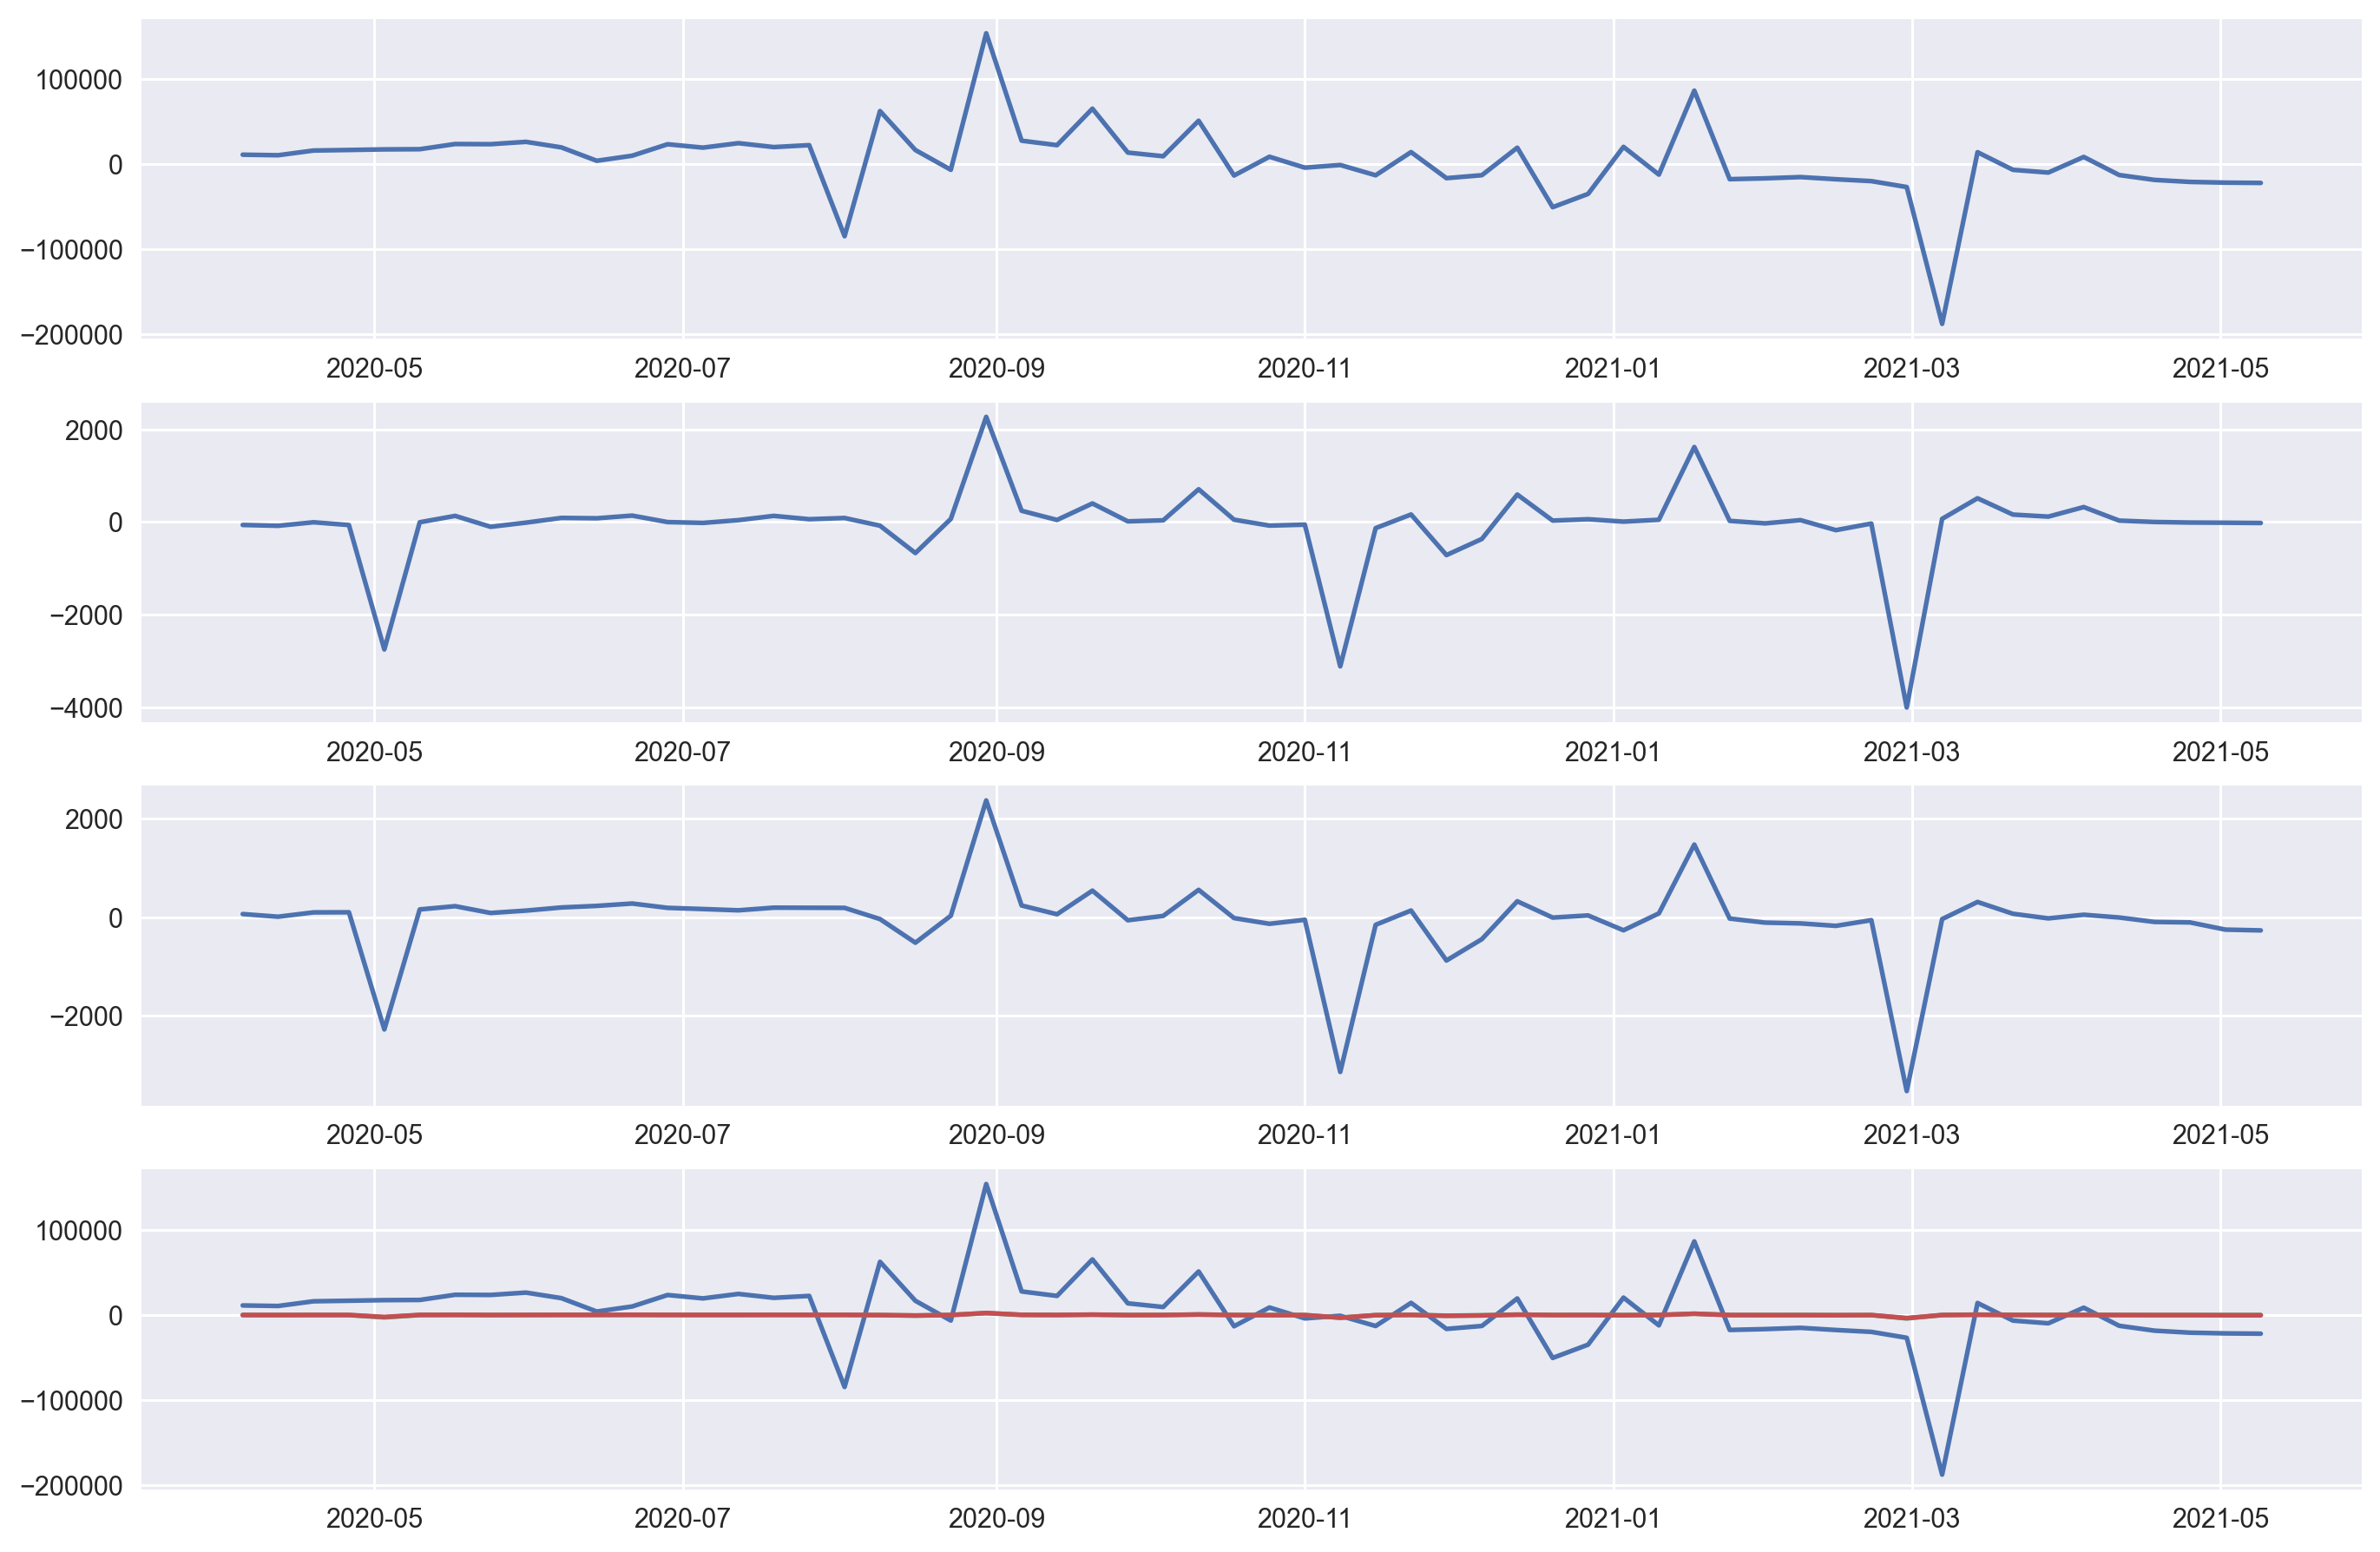

In [83]:
# fig,axes=plt.subplots(nrows=4,ncols=1,figsize=(15,10),dpi=220)
# axes[0].plot(stat[[12844067194]].dropna().index,stat[[12844067194]].dropna())
# axes[1].plot(stat[[12844090321]].dropna().index,stat[[12844090321]].dropna())
# axes[2].plot(stat[[12844090314]].dropna().index,stat[[12844090314]].dropna())
# axes[3].plot(stat[[12844067194]].dropna().index,stat[[12844067194]].dropna())
# axes[3].plot(stat[[12844090321]].dropna().index,stat[[12844090321]].dropna())
# axes[3].plot(stat[[12844090314]].dropna().index,stat[[12844090314]].dropna())
# plt.show()

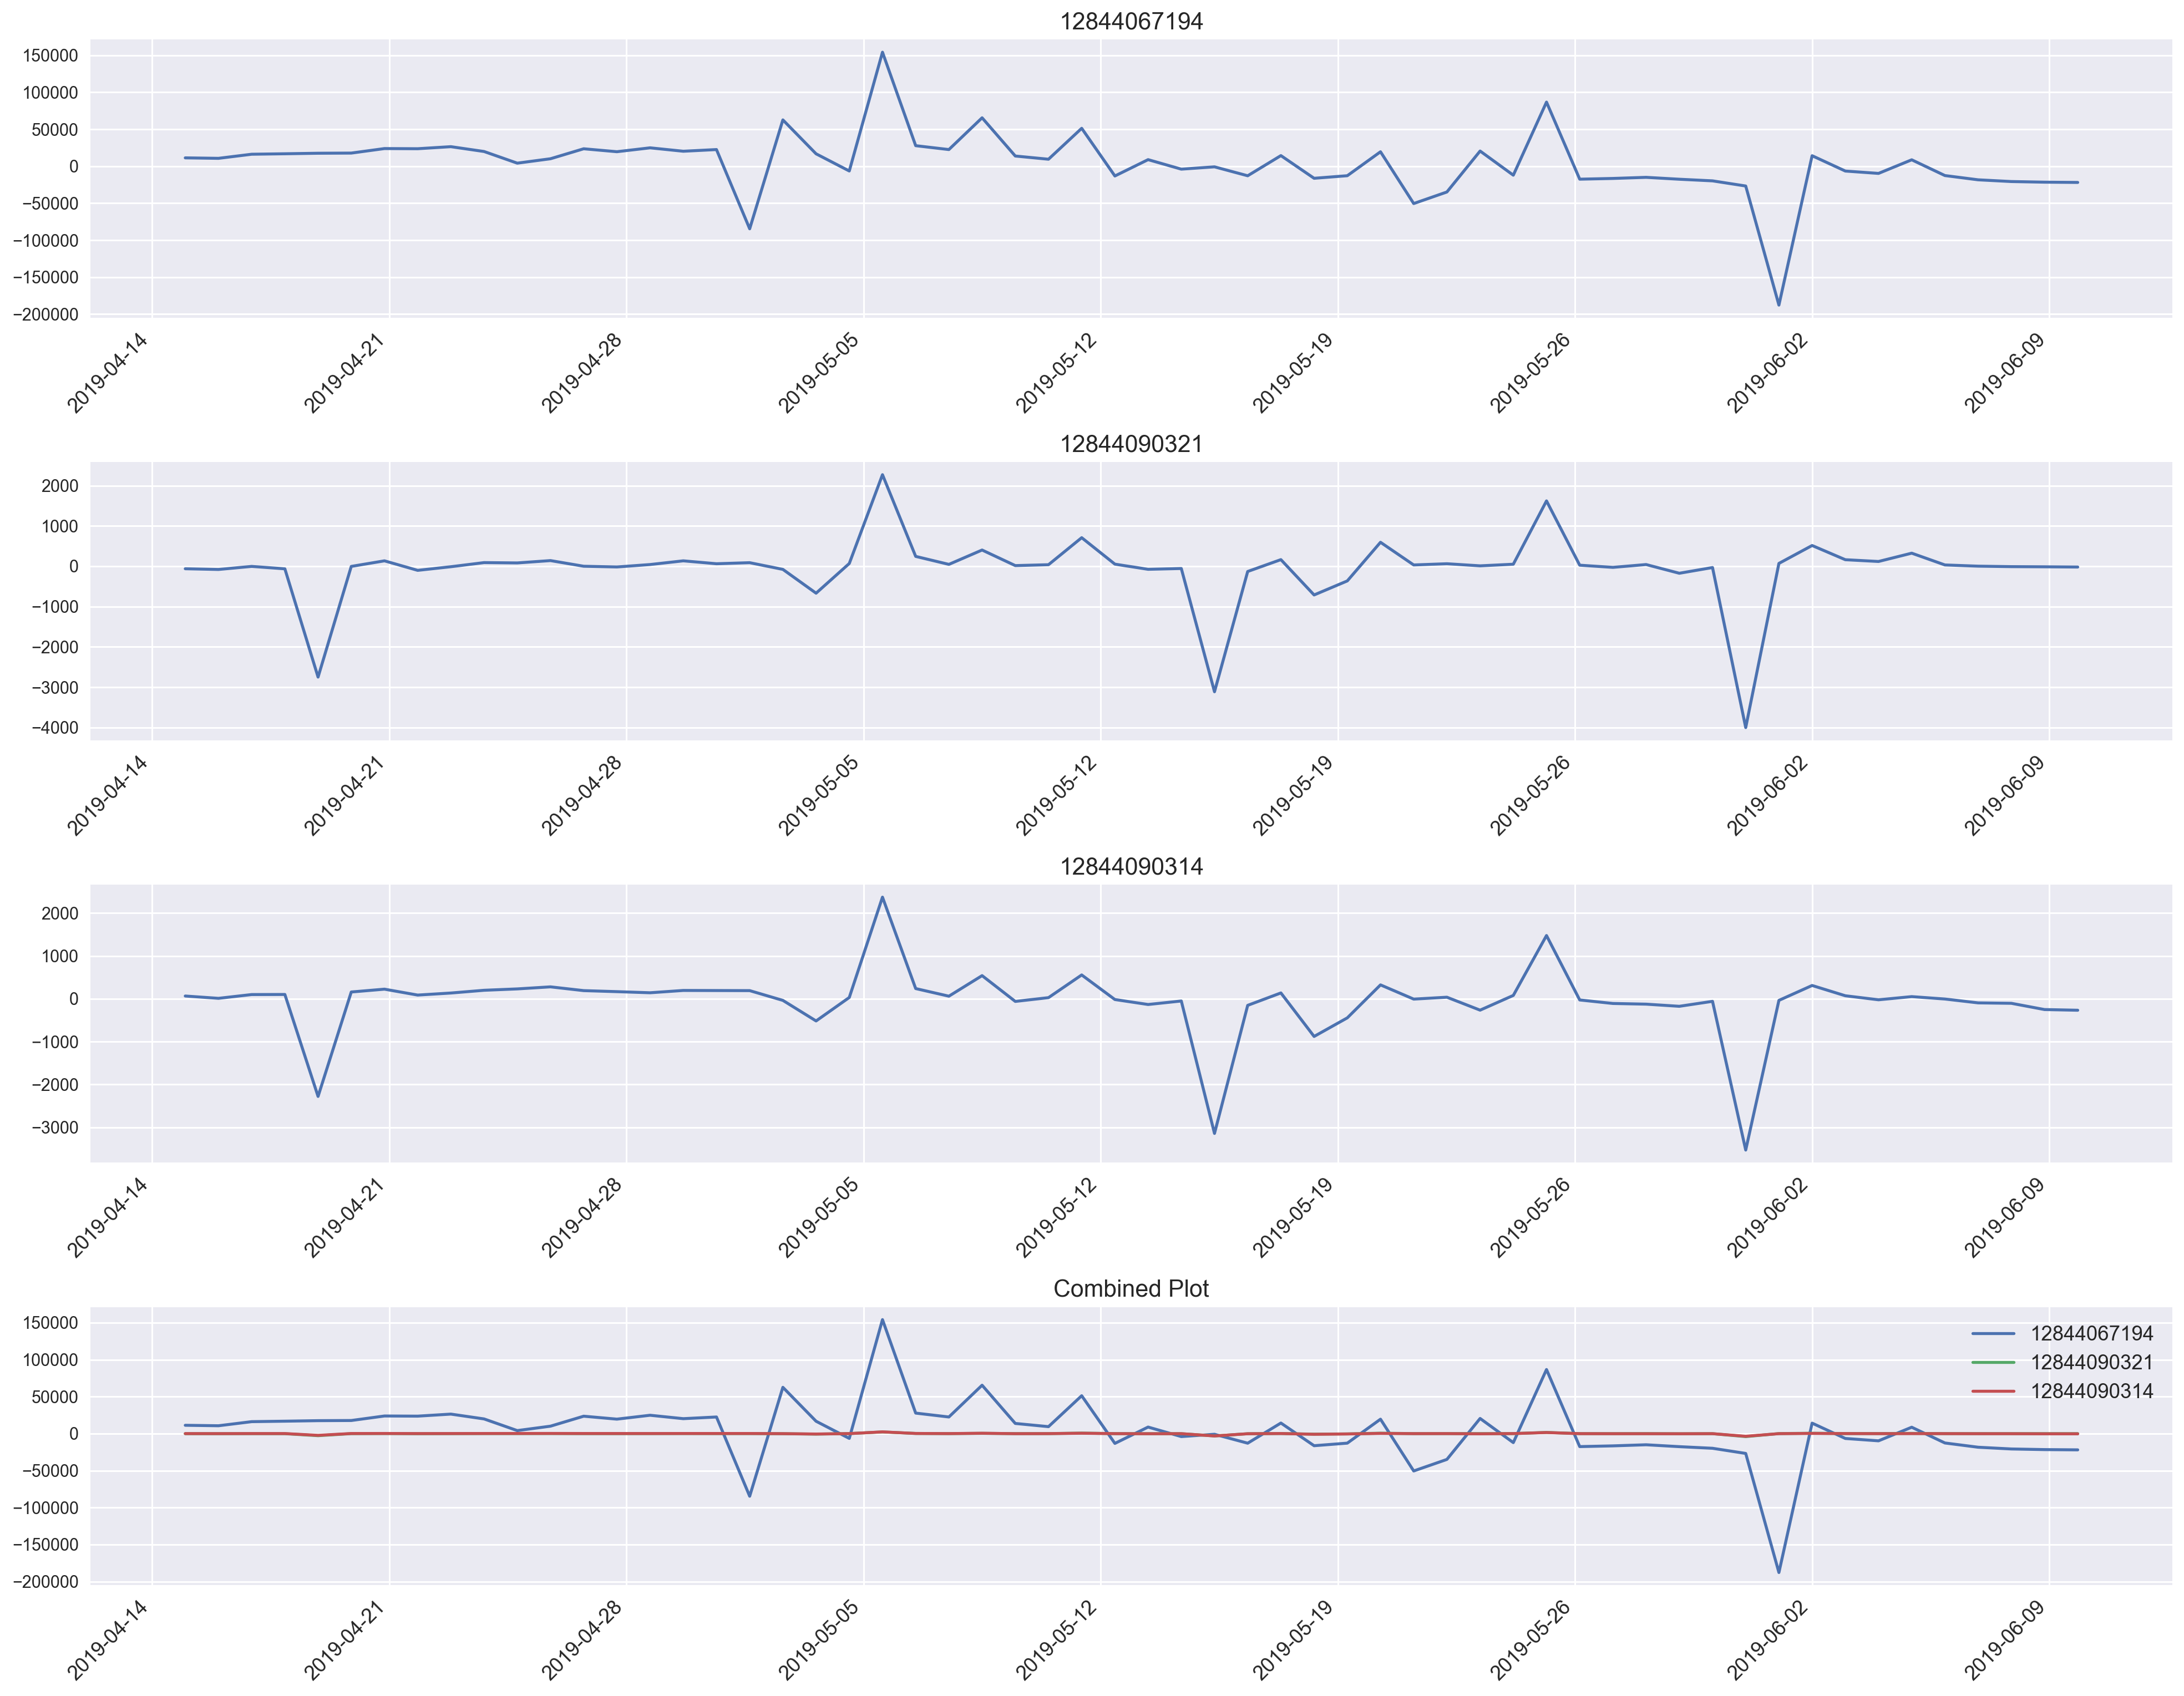

In [85]:
import matplotlib.pyplot as plt

# Assuming 'stat' is your DataFrame and its index is already in datetime format
# Ensure index is datetime (if not already)
stat.index = pd.to_datetime(stat.index)

# Increase figure size
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18, 14), dpi=220)

# Base font size
base_fontsize = 12

# Plotting and setting titles for each subplot
axes[0].plot(stat[[12844067194]].dropna().index, stat[[12844067194]].dropna())
axes[0].set_title('12844067194', fontsize=base_fontsize + 2)

axes[1].plot(stat[[12844090321]].dropna().index, stat[[12844090321]].dropna())
axes[1].set_title('12844090321', fontsize=base_fontsize + 2)

axes[2].plot(stat[[12844090314]].dropna().index, stat[[12844090314]].dropna())
axes[2].set_title('12844090314', fontsize=base_fontsize + 2)

# Plotting multiple lines in the last subplot with labels for legend
axes[3].plot(stat[[12844067194]].dropna().index, stat[[12844067194]].dropna(), label='12844067194')
axes[3].plot(stat[[12844090321]].dropna().index, stat[[12844090321]].dropna(), label='12844090321')
axes[3].plot(stat[[12844090314]].dropna().index, stat[[12844090314]].dropna(), label='12844090314')
axes[3].set_title('Combined Plot', fontsize=base_fontsize + 2)
axes[3].legend(fontsize=base_fontsize)

# Formatting the x-axis to show dates clearly
for ax in axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Adjust the number of x-ticks
    ax.xaxis.set_major_formatter(plt.FixedFormatter(stat.index.strftime('%Y-%m-%d')))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=base_fontsize)  # Rotate date labels for readability

plt.tight_layout()
plt.show()


-------------

### Modelling
---------

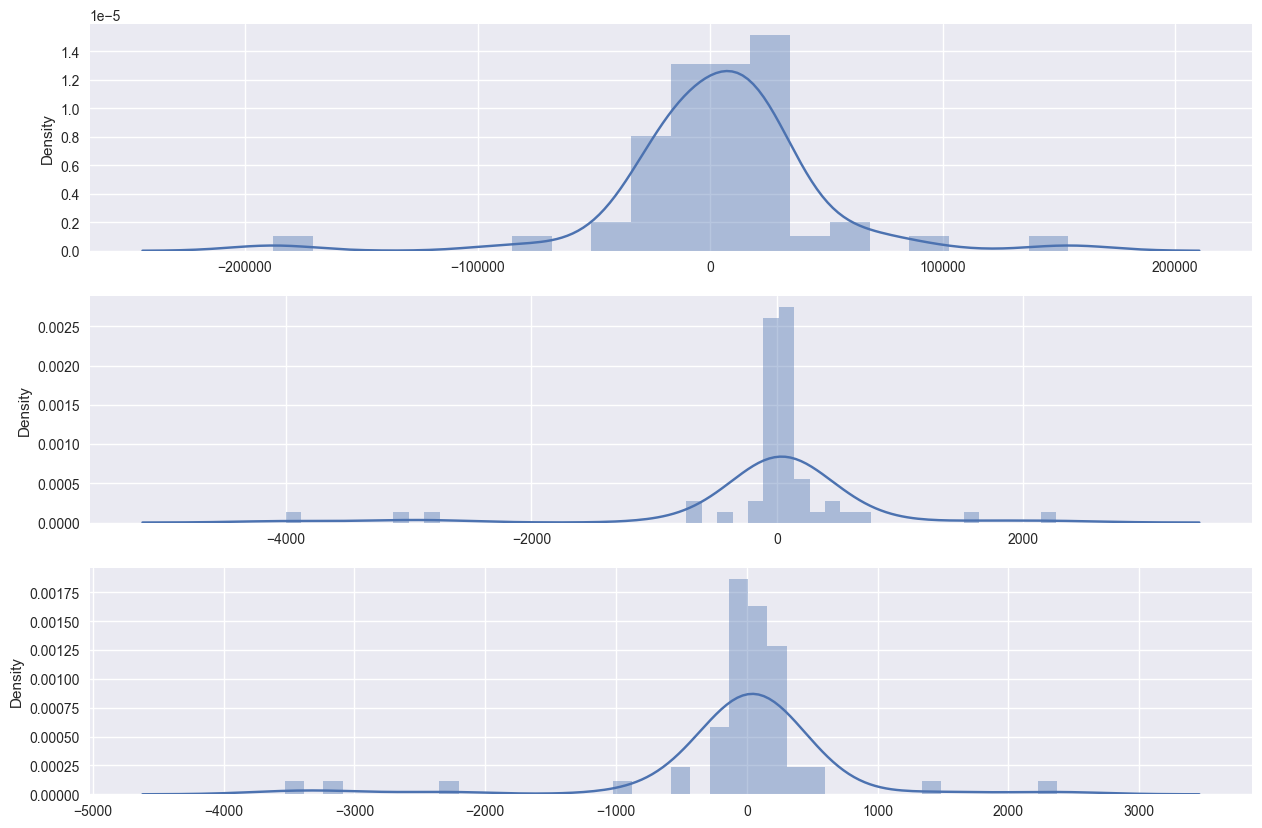

In [86]:
fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(15,10))
sns.distplot(stat[[12844067194]].dropna(),ax=axes[0])
sns.distplot(stat[[12844090321]].dropna(),ax=axes[1])

sns.distplot(stat[[12844090314]].dropna(),ax=axes[2])

plt.show()

In [87]:
from statsmodels.tsa.api import VAR

In [88]:
model=VAR(stat[[12844067194,12844090321,12844090314]].dropna().iloc[:-8])

In [89]:
sorted_order=model.select_order(maxlags=10)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        44.94      45.07*   3.304e+19       44.99
1        44.91       45.42   3.212e+19       45.10
2        45.11       46.00   3.956e+19       45.43
3        45.13       46.40   4.120e+19       45.59
4        44.98       46.63   3.690e+19       45.58
5        44.91       46.94   3.693e+19       45.65
6        45.06       47.47   4.781e+19       45.93
7        45.14       47.93   6.076e+19       46.15
8        45.02       48.19   6.818e+19       46.16
9        44.54       48.08   5.989e+19       45.82
10      41.89*       45.82  7.305e+18*      43.31*
--------------------------------------------------


In [90]:
results = model.fit(maxlags=10, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 11, Jul, 2024
Time:                     23:42:39
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    45.8154
Nobs:                     40.0000    HQIC:                   43.3085
Log likelihood:          -915.048    FPE:                7.30531e+18
AIC:                      41.8888    Det(Omega_mle):     1.30630e+18
--------------------------------------------------------------------
Results for equation 12844067194
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                4934.553420     13054.998503            0.378           0.705
L1.12844067194         -0.376463         0.415596           -0.906           0.365
L1.12844090321        243.511967       100.033

In [91]:
lag_order = results.k_ar
lag_order

10

In [92]:
z = results.forecast(y=stat[[12844067194,12844090321,12844090314]].dropna().iloc[:-8].values,steps = 8)
z

array([[ 3.60477376e+04, -8.51259927e+01, -2.50357117e+02],
       [-1.81026908e+05, -7.90004387e+02, -1.32197452e+03],
       [ 1.47413055e+05,  2.85638812e+02,  1.12897293e+03],
       [-2.54526588e+05,  1.59798905e+02,  1.34125442e+02],
       [ 6.48205309e+04, -2.22455036e+03, -1.81802869e+03],
       [ 2.73408169e+05,  1.17251053e+03,  1.23053092e+03],
       [-9.07234738e+04,  9.78156928e+02,  1.61369057e+02],
       [ 2.82877090e+05,  6.43457371e+03,  7.11501324e+03]])

In [128]:
idx = pd.date_range(start="2021-03-21",periods=8,freq='W')
df_forecast = pd.DataFrame(z,index=idx,columns=[12844067194,12844090321,12844090314])

In [129]:
df_forecast

,12844067194,12844090321,12844090314
2021-03-21,36047.738,-85.126,-250.357
2021-03-28,-181026.908,-790.004,-1321.975
2021-04-04,147413.055,285.639,1128.973
2021-04-11,-254526.588,159.799,134.125
2021-04-18,64820.531,-2224.550,-1818.029
2021-04-25,273408.169,1172.511,1230.531
2021-05-02,-90723.474,978.157,161.369
2021-05-09,282877.090,6434.574,7115.013


In [130]:
p = pd.concat([stat[[12844067194, 12844090321, 12844090314]].iloc[:-8], df_forecast])

In [131]:
p

,12844067194,12844090321,12844090314
2019-04-07,NaN,NaN,NaN
2019-04-14,NaN,NaN,NaN
2019-04-21,NaN,NaN,NaN
2019-04-28,NaN,NaN,NaN
2019-05-05,NaN,NaN,NaN
2019-05-12,NaN,NaN,NaN
2019-05-19,NaN,NaN,NaN
2019-05-26,NaN,NaN,NaN
2019-06-02,NaN,NaN,NaN
2019-06-09,NaN,NaN,NaN


In [132]:
p.columns=['12844067194',12844090321,12844090314]

In [133]:
p

,12844067194,12844090321,12844090314
2019-04-07,NaN,NaN,NaN
2019-04-14,NaN,NaN,NaN
2019-04-21,NaN,NaN,NaN
2019-04-28,NaN,NaN,NaN
2019-05-05,NaN,NaN,NaN
2019-05-12,NaN,NaN,NaN
2019-05-19,NaN,NaN,NaN
2019-05-26,NaN,NaN,NaN
2019-06-02,NaN,NaN,NaN
2019-06-09,NaN,NaN,NaN


In [134]:
k=pd.concat([other_car[[12844067194]],p[['12844067194']]],axis=1,ignore_index=False)

In [135]:
k['pred']=k[12844067194]

In [136]:
k

,12844067194,12844067194,pred
2019-04-07,20732.000,NaN,20732.000
2019-04-14,18034.000,NaN,18034.000
2019-04-21,18105.000,NaN,18105.000
2019-04-28,17821.000,NaN,17821.000
2019-05-05,17040.000,NaN,17040.000
2019-05-12,19667.000,NaN,19667.000
2019-05-19,18602.000,NaN,18602.000
2019-05-26,15691.000,NaN,15691.000
2019-06-02,19170.000,NaN,19170.000
2019-06-09,18247.000,NaN,18247.000


In [137]:
k['pred']=k['pred'].shift(52)+k['12844067194']

In [138]:
k

,12844067194,12844067194,pred
2019-04-07,20732.000,NaN,NaN
2019-04-14,18034.000,NaN,NaN
2019-04-21,18105.000,NaN,NaN
2019-04-28,17821.000,NaN,NaN
2019-05-05,17040.000,NaN,NaN
2019-05-12,19667.000,NaN,NaN
2019-05-19,18602.000,NaN,NaN
2019-05-26,15691.000,NaN,NaN
2019-06-02,19170.000,NaN,NaN
2019-06-09,18247.000,NaN,NaN


### Durbing Watson (Autocorrelation Test)
- The Durbin Watson statistic is a test for autocorrelation in a regression model's output.
- The DW statistic ranges from zero to four, with a value of 2.0 indicating zero autocorrelation.
    - Ideally, residuals shouldn't show any autocorrelation (2.0).
- Values below 2.0 mean there is positive autocorrelation and above 2.0 indicates negative autocorrelation.
    - A stock price displaying positive autocorrelation would indicate that the price yesterday has a positive correlation on the price today—so if the stock fell yesterday, it is also likely that it falls today.
    - A security that has a negative autocorrelation, on the other hand, has a negative influence on itself over time—so that if it fell yesterday, there is a greater likelihood it will rise today.

In [139]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results.resid)

for col, val in zip(stat[[12844067194,12844090321,12844090314]].dropna().columns, out):
    print(col, ':', round(val, 2))

12844067194 : 2.49
12844090321 : 2.6
12844090314 : 2.62


In [140]:
train_df=other_car[[12844067194,12844090321,12844090314]].dropna().iloc[:-8]
test_df=other_car[[12844067194,12844090321,12844090314]].dropna().iloc[-8:]

In [141]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [142]:
train_df.columns=[str(x) for x in train_df.columns]

In [143]:
var_model = VARMAX(train_df, order=(10,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                         Statespace Model Results                                        
Dep. Variable:     ['12844067194', '12844090321', '12844090314']   No. Observations:                  102
Model:                                                   VAR(10)   Log Likelihood               -2544.566
                                                     + intercept   AIC                           5287.131
Date:                                           Fri, 12 Jul 2024   BIC                           5547.004
Time:                                                   00:05:40   HQIC                          5392.362
Sample:                                               04-07-2019                                         
                                                    - 03-14-2021                                         
Covariance Type:                                             opg                                         
Ljung-Box (L1) (Q):       0.02, 0.00, 0.02   J

### Forecasting
---------

In [144]:
n_forecast = 8
predict = fitted_model.get_prediction(start="2021-03-21",end="2021-05-09")#start="1989-07-01",end='1999-01-01')

predictions=predict.predicted_mean

In [145]:
predictions.columns=['12844067194_predicted','12844090321_predicted','12844090314_predicted']
predictions.set_index(test_df.index,inplace=True)
predictions

,12844067194_predicted,12844090321_predicted,12844090314_predicted
2021-03-21,27521.199,642.903,513.100
2021-03-28,21058.567,608.075,450.988
2021-04-04,39549.810,747.034,597.489
2021-04-11,27591.248,633.183,498.765
2021-04-18,28932.712,717.226,578.508
2021-04-25,33235.606,611.258,489.872
2021-05-02,27439.607,628.524,500.441
2021-05-09,25679.470,540.287,427.905


### Plotting Results
---------

In [148]:
test_vs_pred=pd.concat([test_df,predictions],axis=1,ignore_index=False)

In [149]:
test_vs_pred

,12844067194,12844090321,12844090314,12844067194_predicted,12844090321_predicted,12844090314_predicted
2021-03-21,16117.000,418.000,328.000,27521.199,642.903,513.100
2021-03-28,18460.000,410.000,282.000,21058.567,608.075,450.988
2021-04-04,40683.000,694.000,450.000,39549.810,747.034,597.489
2021-04-11,16046.000,372.000,308.000,27591.248,633.183,498.765
2021-04-18,15904.000,384.000,308.000,28932.712,717.226,578.508
2021-04-25,13916.000,368.000,318.000,33235.606,611.258,489.872
2021-05-02,12993.000,344.000,202.000,27439.607,628.524,500.441
2021-05-09,15478.000,404.000,238.000,25679.470,540.287,427.905


In [151]:
test_vs_pred[[test_vs_pred.columns[0],test_vs_pred.columns[6]]]

,12844067194,12844067194_predicted
2021-03-21,16117.000,27521.199
2021-03-28,18460.000,21058.567
2021-04-04,40683.000,39549.810
2021-04-11,16046.000,27591.248
2021-04-18,15904.000,28932.712
2021-04-25,13916.000,33235.606
2021-05-02,12993.000,27439.607
2021-05-09,15478.000,25679.470


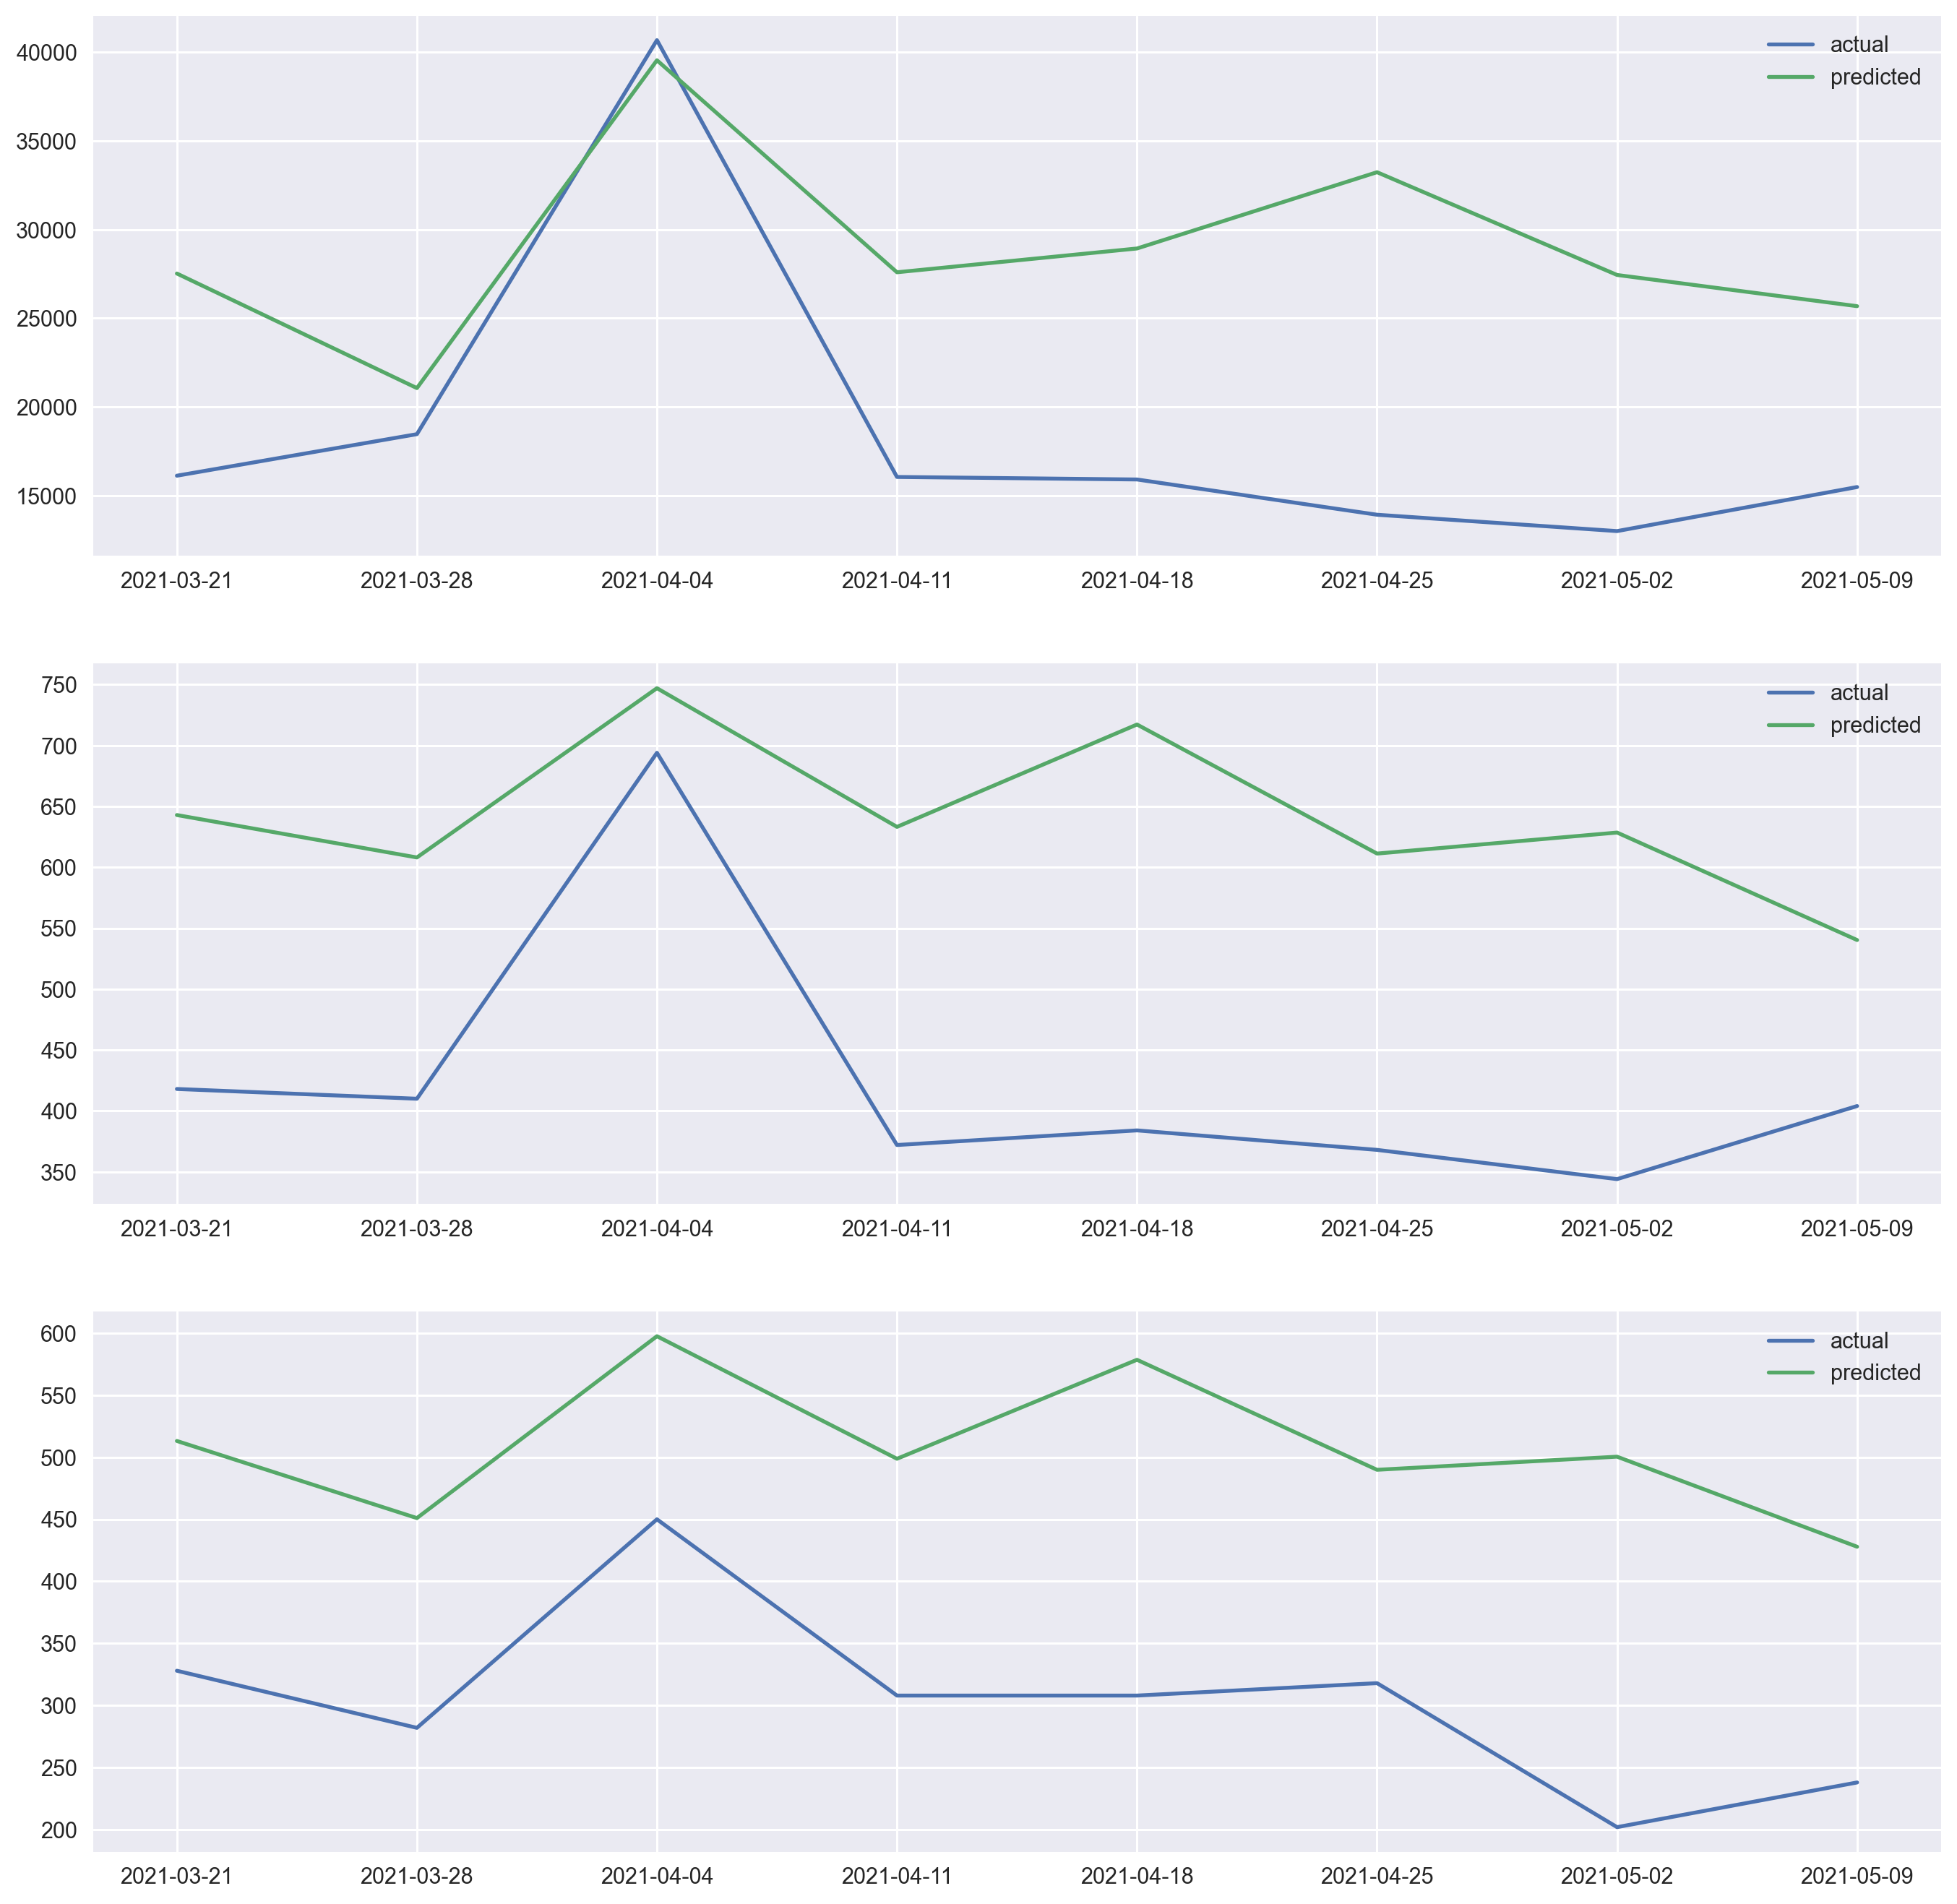

In [152]:
fig,ax=plt.subplots(nrows=3,ncols=1,dpi=220,figsize=(15,15))
ax[0].plot(test_vs_pred.index,test_vs_pred[test_vs_pred.columns[0]])
ax[0].plot(test_vs_pred.index,test_vs_pred[test_vs_pred.columns[0+3]])

ax[1].plot(test_vs_pred.index,test_vs_pred[test_vs_pred.columns[1]])
ax[1].plot(test_vs_pred.index,test_vs_pred[test_vs_pred.columns[1+3]])

ax[2].plot(test_vs_pred.index,test_vs_pred[test_vs_pred.columns[2]])
ax[2].plot(test_vs_pred.index,test_vs_pred[test_vs_pred.columns[2+3]])


ax[0].legend(['actual','predicted'])
ax[1].legend(['actual','predicted'])
ax[2].legend(['actual','predicted'])
plt.show()

### Error Metrics
---------

In [153]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [154]:
print("For SKU: 12844067194; MAPE is : {}".format(MAPE(test_vs_pred[[12844067194]], test_vs_pred[['12844067194_predicted']])))
print("For SKU: 12844090321; MAPE is : {}".format(MAPE(test_vs_pred[[12844090321]], test_vs_pred[['12844090321_predicted']])))
print("For SKU: 12844090314; MAPE is : {}".format(MAPE(test_vs_pred[[12844090314]], test_vs_pred[['12844090314_predicted']])))
#print("For SKU: 9311412400014; MAPE is : {}".format(MAPE(test_vs_pred[[9311412400014]], test_vs_pred[['9311412400014_predicted']])))



For SKU: 12844067194; MAPE is : 69.67752081450254
For SKU: 12844090321; MAPE is : 56.16161050749218
For SKU: 12844090314; MAPE is : 72.56003557583026


In [155]:
from sklearn.metrics import mean_squared_error
import math

rmse_item1=math.sqrt(mean_squared_error(test_vs_pred[[12844067194]], test_vs_pred[['12844067194_predicted']]))
print('Mean value of SKU: 12844082043 is : {}.\nRoot Mean Squared Error is :{}'.format(np.mean(test_vs_pred[12844067194]),rmse_item1))
print("-"*30)
rmse_item2=math.sqrt(mean_squared_error(test_vs_pred[[12844090321]], test_vs_pred[['12844090321_predicted']]))
print('Mean value of SKU: 12844090321 is : {}.\nRoot Mean Squared Error is :{}'.format(np.mean(test_vs_pred[12844090321]),rmse_item2))
print("-"*30)
rmse_item3=math.sqrt(mean_squared_error(test_vs_pred[[12844090314]], test_vs_pred[['12844090314_predicted']]))
print('Mean value of SKU: 12844090314 is : {}.\nRoot Mean Squared Error is :{}'.format(np.mean(test_vs_pred[12844090314]),rmse_item3))
print("-"*30)
#rmse_item4=math.sqrt(mean_squared_error(test_vs_pred[[9311412400014]], test_vs_pred[['9311412400014_predicted']]))
#print('Mean value of SKU: 9311412400014 is : {}.\nRoot Mean Squared Error is :{}'.format(np.mean(test_vs_pred[9311412400014]),rmse_item4))

Mean value of SKU: 12844082043 is : 18699.625.
Root Mean Squared Error is :11869.889131415757
------------------------------
Mean value of SKU: 12844090321 is : 424.25.
Root Mean Squared Error is :231.99843037307923
------------------------------
Mean value of SKU: 12844090314 is : 304.25.
Root Mean Squared Error is :208.80887527280376
------------------------------


-------------------

In [156]:
plt.style.use('Solarize_Light2')

In [157]:
item=12844067194

In [158]:
other_car_item=other_car[[12844067194]].diff()

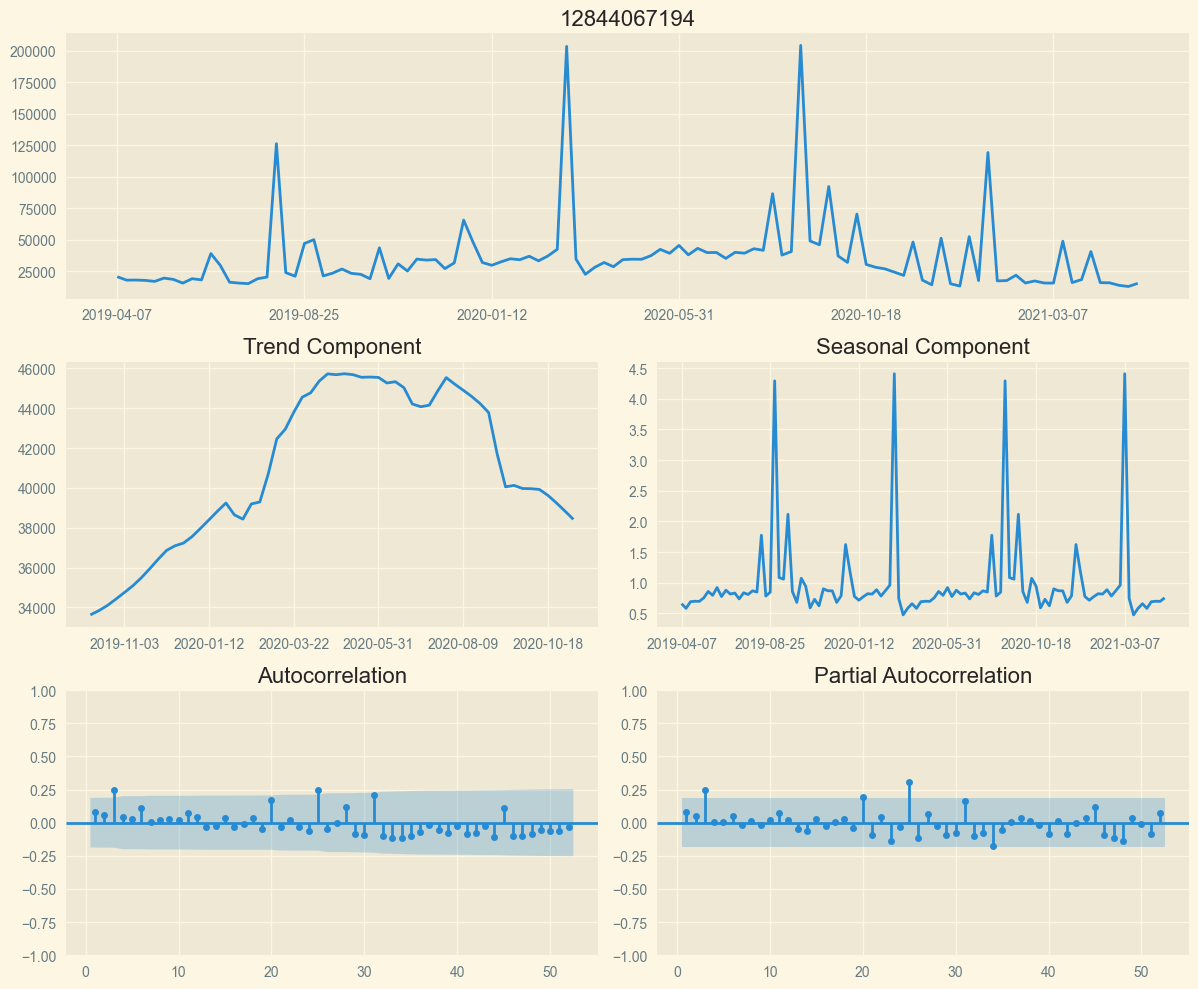

In [159]:
if 0 in other_car[12844067194].values:
    plot_stationarity(other_car[12844067194],52,'additive')
else:
    plot_stationarity(other_car[12844067194],52,'multiplicative')

In [166]:
check_stationarity2(other_car[[12844067194]])

,Item,Results,ADF,KPSS
0,12844067194,Test Statistics,-4.255,0.325
1,12844067194,p-value,0.001,0.100
2,12844067194,Differencing Required,False,False
3,12844067194,Conclusion,stationary,stationary


In [167]:
# Create Training and Test
train = other_car[[12844067194]].iloc[:-8]
test = other_car[[12844067194]].iloc[-8:]

In [168]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2401.756, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2398.395, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2399.976, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2400.099, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2489.815, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.190 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  102
Model:                        SARIMAX   Log Likelihood               -1197.198
Date:                Fri, 12 Jul 2024   AIC                           2398.395
Time:                        00:17:47   BIC                           2403.645
Sample:                    04-07-2019   HQIC                          2400.521
                         - 03-14-2021                                       

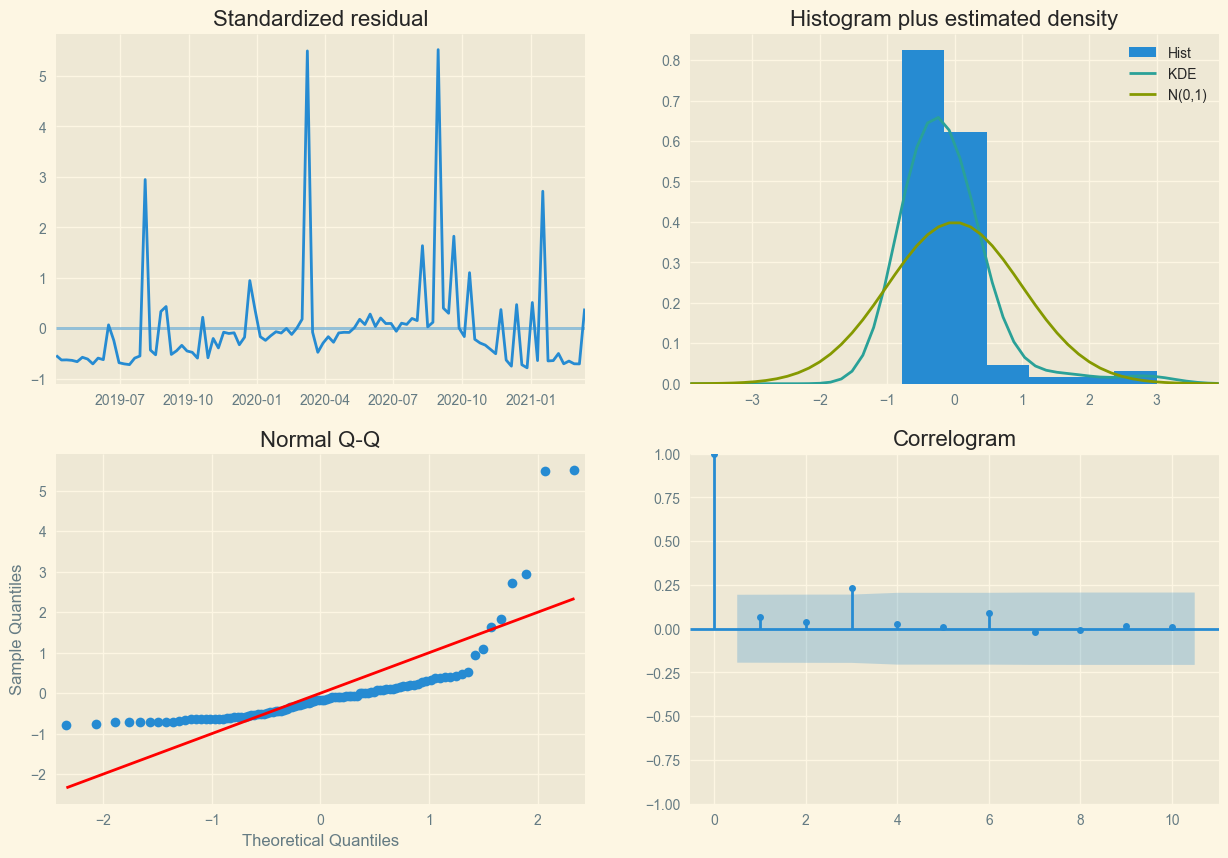

In [169]:
model.plot_diagnostics(figsize=(15,10))
plt.show()

---------------

